In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV3Large  # Assuming you want to use MobileNetV3Large
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [6]:
# Constants
INIT_LR = 1e-4
EPOCHS = 20
BS = 32


In [7]:
# Directory containing the data
DIRECTORY = r'C:\Users\aisho\OneDrive\Desktop\data'
CATEGORIES = ['fake', 'real']

In [4]:
# Data loading and preprocessing
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)  # Preprocessing specific to MobileNetV3
        data.append(image)
        labels.append(category)


C:\Users\aisho\anaconda3\envs\tf_new\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
# Convert labels to one-hot encoded format
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
# Convert data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [10]:
# Split data into training and testing sets
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [11]:
# Data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [12]:
# Load pre-trained MobileNetV3 model without the top (fully connected) layers
baseModel = MobileNetV3Large(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model to be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# Place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

12683000/12683000 [==============================] - 10s 1us/step


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
# Compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

C:\Users\aisho\anaconda3\envs\tf_new\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
164/164 [==============================] - 327s 2s/step - loss: 0.6389 - accuracy: 0.6812 - val_loss: 0.4886 - val_accuracy: 0.7854
Epoch 2/20
164/164 [==============================] - 257s 2s/step - loss: 0.5308 - accuracy: 0.7551
Epoch 3/20
164/164 [==============================] - 282s 2s/step - loss: 0.4639 - accuracy: 0.7944
Epoch 4/20
164/164 [==============================] - 248s 2s/step - loss: 0.4246 - accuracy: 0.8242
Epoch 5/20
164/164 [==============================] - 250s 2s/step - loss: 0.3969 - accuracy: 0.8373
Epoch 6/20
164/164 [==============================] - 259s 2s/step - loss: 0.3690 - accuracy: 0.8489
Epoch 7/20
164/164 [==============================] - 336s 2s/step - loss: 0.3437 - accuracy: 0.8625
Epoch 8/20
164/164 [==============================] - 245s 1s/step - loss: 0.3275 - accuracy: 0.8698
Epoch 9/20
164/164 [==============================] - 290s 2s/step - loss: 0.3113 - accuracy: 0.8723
Epoch 10/20
164/164 [============================

In [15]:
# Evaluate the model
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
true_labels = np.argmax(testY, axis=1)

42/42 [==============================] - 34s 724ms/step


In [16]:
# Print classification report
print(classification_report(true_labels, predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

        fake       0.93      0.97      0.95       468
        real       0.98      0.96      0.97       846

    accuracy                           0.96      1314
   macro avg       0.95      0.96      0.96      1314
weighted avg       0.96      0.96      0.96      1314



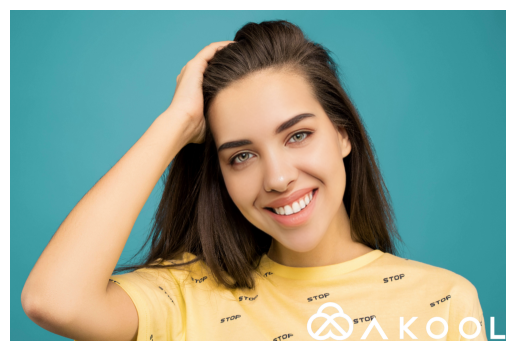

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
image_path = r"C:\Users\aisho\Downloads\final_material1__a92671d0-7960-4028-b2fc-aadd3541f32d-ef10b3c3-effc-4962-b369-9e485044920e-9876.jpg"
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Load and preprocess the image
image_path = r"C:\Users\aisho\Downloads\final_material1__a92671d0-7960-4028-b2fc-aadd3541f32d-ef10b3c3-effc-4962-b369-9e485044920e-9876.jpg"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = preprocess_input(image_array.reshape(1, 224, 224, 3))

# Make predictions
predictions = model.predict(image_array)
predicted_class_index = np.argmax(predictions, axis=1)

# Convert the predicted index to class label using LabelBinarizer
predicted_class_label = lb.classes_[predicted_class_index[0]]

print(f"The predicted class is: {predicted_class_label}")

1/1 [==============================] - 0s 46ms/step
The predicted class is: fake


In [ ]:
# Visualize training history (loss and accuracy)
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, predIdxs)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()